## Cincinnati Logistic and Poisson Regression (Proof of Concept)
##### Code by Drew Gobbi 12/3/2019

### Import Packages and Data Cleaning 

In [348]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import geopandas as gpd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from time import strptime
import os 
import patsy 
from shapely.wkt import loads
import pickle

In [349]:
pkl_in_Cin = open('countMedicalFacilitiesWithin2milesCinbyTract.pkl', 'rb')

fac = pickle.load(pkl_in_Cin)

In [350]:
fac.head()

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,HospitalsChildCount2mi,ChildFacilitiesCount2mi,PharmCount2mi,DrugDropCount2mi,NaloxoneDistribCount2mi,geometry
0,52.00,3,1,7,6,0,1,2,1,1,9,9,2,0,0,13,1,16,"POLYGON ((-84.43168 39.15720, -84.43177 39.156..."
1,53.01,2,1,7,6,0,1,2,1,1,9,7,2,0,0,15,0,13,"POLYGON ((-84.42516 39.15576, -84.42513 39.155..."
2,53.02,1,1,4,5,0,1,3,1,1,7,8,1,0,0,12,0,12,"POLYGON ((-84.40766 39.15576, -84.40748 39.155..."
3,54.00,2,1,7,6,0,1,2,1,1,9,6,2,0,0,15,0,12,"POLYGON ((-84.42096 39.16456, -84.41972 39.163..."
4,55.00,1,1,2,4,0,1,3,0,1,6,10,1,0,0,11,0,11,"MULTIPOLYGON (((-84.39309 39.16722, -84.39303 ..."


In [351]:
fac.dtypes

CensusTract                        object
HospitalsGeneralCount2mi            int64
HospitalsPsychCount2mi              int64
SurgicalCentersCount2mi             int64
UrgentCareCount2mi                  int64
WomensClinicsCount2mi               int64
PainManagementCount2mi              int64
PhysicalTherapyCount2mi             int64
MentalFacilitiesCount2mi            int64
SubstanceAbuseCount2mi              int64
OtherMedicalFacilitesCount2mi       int64
NursingAssistedLiveCount2mi         int64
HospiceCount2mi                     int64
HospitalsChildCount2mi              int64
ChildFacilitiesCount2mi             int64
PharmCount2mi                       int64
DrugDropCount2mi                    int64
NaloxoneDistribCount2mi             int64
geometry                         geometry
dtype: object

In [352]:
pdb = pd.read_csv('pdb2019trv6_us.csv',encoding = "ISO-8859-1")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (286) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [353]:
cin = pdb[(pdb['State_name'] == 'Ohio') ]
print(cin)
print(cin.columns)

             GIDTR  State State_name  County     County_name   Tract  Flag  \
50530  39001770100     39       Ohio       1    Adams County  770100   NaN   
50531  39001770200     39       Ohio       1    Adams County  770200   NaN   
50532  39001770300     39       Ohio       1    Adams County  770300   NaN   
50533  39001770400     39       Ohio       1    Adams County  770400   NaN   
50534  39001770500     39       Ohio       1    Adams County  770500   NaN   
...            ...    ...        ...     ...             ...     ...   ...   
53477  39175938100     39       Ohio     175  Wyandot County  938100   NaN   
53478  39175938200     39       Ohio     175  Wyandot County  938200   NaN   
53479  39175938300     39       Ohio     175  Wyandot County  938300   NaN   
53480  39175938400     39       Ohio     175  Wyandot County  938400   NaN   
53481  39175938500     39       Ohio     175  Wyandot County  938500   NaN   

       Num_BGs_in_Tract  LAND_AREA  AIAN_LAND  ...  \
50530    

In [354]:
var = ['Med_HHD_Inc_ACS_13_17', 'Median_Age_ACS_13_17','pct_College_ACS_13_17',
       'pct_Not_HS_Grad_ACS_13_17','pct_NoHealthIns_65P_ACS_13_17',
       'pct_NH_White_alone_ACS_13_17','pct_NH_AIAN_alone_ACS_13_17', 'pct_Males_ACS_13_17', 'pct_Pop_18_24_ACS_13_17',
       'pct_Pop_65plus_ACS_13_17','pct_Prs_Blw_Pov_Lev_ACS_13_17', 'pct_One_Health_Ins_ACS_13_17'
       ,'pct_Two_Plus_Health_Ins_ACS_13_17','pct_Civ_labor_16plus_ACS_13_17','pct_Civ_unemp_16plus_ACS_13_17',
        'pct_Civ_labor_16_24_ACS_13_17','pct_Civ_unemp_16_24_ACS_13_17','pct_Civ_labor_25_44_ACS_13_17',
       'pct_Civ_labor_45_64_ACS_13_17','pct_Civ_unemp_45_64_ACS_13_17','pct_PUB_ASST_INC_ACS_13_17','Tract']
"""var = ['Med_HHD_Inc_ACS_13_17', 'pct_College_ACS_13_17', 'pct_Males_ACS_13_17', 'pct_Pop_18_24_ACS_13_17',
      'pct_Pop_25_44_ACS_13_17', 'Tract']"""

"var = ['Med_HHD_Inc_ACS_13_17', 'pct_College_ACS_13_17', 'pct_Males_ACS_13_17', 'pct_Pop_18_24_ACS_13_17',\n      'pct_Pop_25_44_ACS_13_17', 'Tract']"

In [355]:
cin = cin.filter(var)
cin.Tract=cin.Tract.astype(float)
print(cin)

      Med_HHD_Inc_ACS_13_17  Median_Age_ACS_13_17  pct_College_ACS_13_17  \
50530               $32,911                  43.4                  13.71   
50531               $45,590                  38.9                  14.23   
50532               $49,911                  41.2                  11.12   
50533               $25,051                  45.1                  14.74   
50534               $34,015                  41.7                   6.06   
...                     ...                   ...                    ...   
53477               $49,848                  38.9                  10.95   
53478               $56,504                  39.3                  13.63   
53479               $47,534                  39.1                  17.39   
53480               $41,860                  37.4                  16.96   
53481               $44,625                  48.2                  11.23   

       pct_Not_HS_Grad_ACS_13_17  pct_NoHealthIns_65P_ACS_13_17  \
50530               

In [356]:
#align labeling of tracts between fac and pdb - need codes w/o decimals
fac.CensusTract = fac.CensusTract.astype(float)
#fac.CensusTract = int(fac.CensusTract)
fac.CensusTract = fac.CensusTract *100

print(fac)

     CensusTract  HospitalsGeneralCount2mi  HospitalsPsychCount2mi  \
0         5200.0                         3                       1   
1         5301.0                         2                       1   
2         5302.0                         1                       1   
3         5400.0                         2                       1   
4         5500.0                         1                       1   
..           ...                       ...                     ...   
121       4702.0                         0                       0   
122       4800.0                         0                       0   
123       4900.0                         1                       0   
124       5000.0                         2                       0   
125       5100.0                         1                       0   

     SurgicalCentersCount2mi  UrgentCareCount2mi  WomensClinicsCount2mi  \
0                          7                   6                      0   
1        

In [357]:
df = fac.merge(cin, left_on='CensusTract', right_on='Tract')

In [358]:
df

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,...,pct_NH_AIAN_alone_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,pct_One_Health_Ins_ACS_13_17,pct_Civ_unemp_16_24_ACS_13_17,pct_Civ_unemp_45_64_ACS_13_17,pct_PUB_ASST_INC_ACS_13_17,Tract
0,5200.0,3,1,7,6,0,1,2,1,1,...,0.00,51.75,9.17,8.44,4.27,87.95,0.00,3.77,0.67,5200.0
1,5200.0,3,1,7,6,0,1,2,1,1,...,0.00,53.27,11.99,7.04,7.37,84.84,0.00,12.88,0.33,5200.0
2,5200.0,3,1,7,6,0,1,2,1,1,...,1.85,49.85,15.67,11.68,24.18,78.57,8.35,8.78,5.83,5200.0
3,5301.0,2,1,7,6,0,1,2,1,1,...,0.50,45.00,10.18,13.99,13.94,85.84,7.69,1.72,0.64,5301.0
4,5302.0,1,1,4,5,0,1,3,1,1,...,0.00,47.86,12.31,22.90,12.41,72.30,1.53,0.00,1.01,5302.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,5000.0,2,0,6,5,0,0,1,2,0,...,0.00,44.76,10.85,13.25,5.44,86.99,6.52,0.00,1.96,5000.0
380,5000.0,2,0,6,5,0,0,1,2,0,...,0.00,52.34,10.53,11.12,25.46,76.12,23.33,12.42,5.81,5000.0
381,5100.0,1,0,4,5,0,1,2,1,1,...,0.00,48.26,8.44,7.64,75.65,67.40,0.00,17.78,18.86,5100.0
382,5100.0,1,0,4,5,0,1,2,1,1,...,0.00,48.17,7.80,9.75,5.16,90.41,2.26,0.00,0.68,5100.0


In [359]:
df.shape

(384, 35)

In [360]:
df.columns

Index(['CensusTract', 'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi',
       'SurgicalCentersCount2mi', 'UrgentCareCount2mi',
       'WomensClinicsCount2mi', 'PainManagementCount2mi',
       'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi',
       'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi',
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi',
       'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi', 'PharmCount2mi',
       'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'geometry',
       'Med_HHD_Inc_ACS_13_17', 'Median_Age_ACS_13_17',
       'pct_College_ACS_13_17', 'pct_Not_HS_Grad_ACS_13_17',
       'pct_NoHealthIns_65P_ACS_13_17', 'pct_NH_White_alone_ACS_13_17',
       'pct_NH_AIAN_alone_ACS_13_17', 'pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17', 'pct_Pop_65plus_ACS_13_17',
       'pct_Prs_Blw_Pov_Lev_ACS_13_17', 'pct_One_Health_Ins_ACS_13_17',
       'pct_Civ_unemp_16_24_ACS_13_17', 'pct_Civ_unemp_45_64_ACS_13_17',
       'pct_PUB_ASST_INC_

In [361]:
fac.columns

Index(['CensusTract', 'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi',
       'SurgicalCentersCount2mi', 'UrgentCareCount2mi',
       'WomensClinicsCount2mi', 'PainManagementCount2mi',
       'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi',
       'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi',
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi',
       'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi', 'PharmCount2mi',
       'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'geometry'],
      dtype='object')

### Get EMS Data

In [72]:
pip install sodapy

Note: you may need to restart the kernel to use updated packages.


In [362]:
from sodapy import Socrata
client = Socrata("data.cincinnati-oh.gov", None)
results = client.get("3gx7-se9a", limit=11000)

# Convert to pandas DataFrame
ems = pd.DataFrame.from_records(results)

In [141]:
ems.to_csv('cincy_ems.csv')

In [363]:
ems.head()

,address_x,latitude_x,longitude_x,agency,create_time_incident,disposition_text,event_number,incident_type_id,priority,closed_time_incident,beat,community_council_neighborhood,district,incident_type_desc,priority_color,arrival_time_primary_unit,dispatch_time_primary_unit
0,16XX CALIFORNIA AV,39.1754784436823,-84.4670395218747,CPD,2017-05-16T20:35:05.000,BC: BROADCAST,CPD170516001810,DRUG,3,2017-05-16T20:40:39.000,P451,BOND HILL,4,NaN,NaN,NaN,NaN
1,16XX ILIFF AV,39.1177910001195,-84.580431,CPD,2017-10-13T21:25:58.000,INV: INV,CPD171013002052,DRUG,7,2017-10-13T22:16:51.000,P321,WEST PRICE HILL,3,DRUG ACTIVITY,YELLOW,2017-10-13T21:58:24.000,2017-10-13T21:44:59.000
2,21XX CLARA ST,39.1227367321796,-84.5518912925694,CPD,2017-03-22T20:41:51.000,AST: ASSIST,CPD170322001510,HEROINP-COMBINED,2,2017-03-23T02:13:01.000,P341,SOUTH FAIRMOUNT,3,NaN,NaN,2017-03-22T21:04:18.000,2017-03-22T20:52:13.000
3,13XX VINE ST,39.1095160001195,-84.515049,CPD,2017-12-13T02:29:05.000,INV: INV,CPD171213000116,DRUG,7,2017-12-13T02:44:10.000,P121,OTR,1,DRUG ACTIVITY,YELLOW,2017-12-13T02:31:36.000,2017-12-13T02:30:06.000
4,2XX W MCMICKEN AV,39.1194960001195,-84.524441,CPD,2017-09-05T16:28:05.000,ADV:ADVISED,CPD170905001184,DRUGR,35,2017-09-05T16:28:05.000,P121,OTR,1,DRUG COMPLAINT REFERRAL,PURPLE,NaN,NaN


In [364]:
ems.longitude_x = ems.longitude_x.astype(float)
ems.latitude_x = ems.latitude_x.astype(float)

In [365]:
ems_gdf = gpd.GeoDataFrame(
    ems, geometry=gpd.points_from_xy(ems.longitude_x, ems.latitude_x))

In [555]:
cin_gdf = gpd.GeoDataFrame(df, geometry=df.geometry)

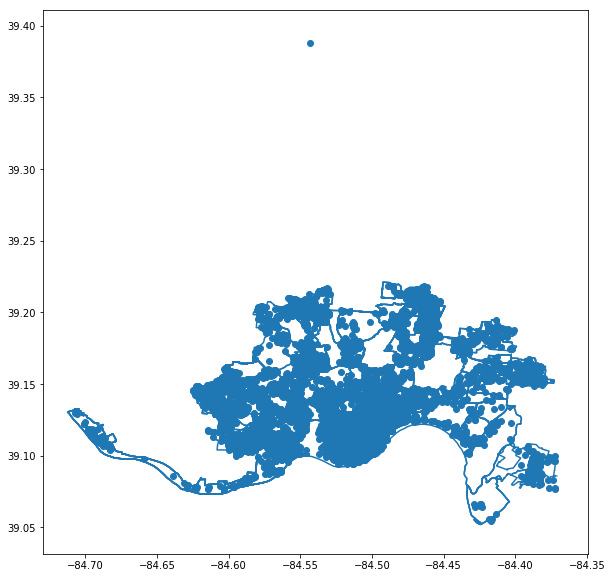

In [473]:
fig, ax = plt.subplots(figsize=(10,10))
ems_gdf.plot(ax=ax)
cin_gdf.boundary.plot(ax=ax)

In [556]:
out = pd.DataFrame()
for i in range(len(cin_gdf)):
    temp = ems_gdf[ems_gdf.within(cin_gdf.loc[i,'geometry'])]
    temp['tract'] = cin_gdf.loc[i,'Tract']
    out = pd.concat([out, temp])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [369]:
len(out)

37072

In [370]:
len(ems)

10498

In [557]:
out.closed_time_incident = pd.to_datetime(out.closed_time_incident)

In [558]:
out['year_month'] = out.closed_time_incident.dt.year.astype(float) + out.closed_time_incident.dt.month.astype(float)/100

In [559]:
out.head()

,address_x,latitude_x,longitude_x,agency,create_time_incident,disposition_text,event_number,incident_type_id,priority,closed_time_incident,beat,community_council_neighborhood,district,incident_type_desc,priority_color,arrival_time_primary_unit,dispatch_time_primary_unit,geometry,tract,year_month
89,27XX MADISON RD,39.145535,-84.440570,CPD,2017-06-07T13:22:45.000,INV: INV,CPD170607000895,DRUG,7,2017-06-07 13:52:13,P222,HYDE PARK - OAKLEY,2,DRUG ACTIVITY,YELLOW,2017-06-07T13:35:34.000,2017-06-07T13:29:19.000,POINT (-84.44057 39.14553),5200.0,2017.06
1022,MADISON RD / EDWARDS RD,39.145584,-84.441808,CPD,2017-06-07T00:44:41.000,SOW: SENT ON WAY,CPD170607000050,DRUG,7,2017-06-07 01:23:36,P222,HYDE PARK - OAKLEY,2,DRUG ACTIVITY,YELLOW,2017-06-07T00:58:58.000,2017-06-07T00:58:57.000,POINT (-84.44181 39.14558),5200.0,2017.06
1865,38XX MILLSBRAE AV,39.149455,-84.440186,CPD,2017-06-21T20:34:49.000,ADV:ADVISED,CPD170621001651,DRUGR,35,2017-06-21 20:34:49,P222,OAKLEY,2,DRUG COMPLAINT REFERRAL,PURPLE,NaN,NaN,POINT (-84.44019 39.14946),5200.0,2017.06
3017,ATLANTIC AV / MILLSBRAE AV,39.148527,-84.439880,CPD,2017-10-23T22:18:45.000,ADV:ADVISED,CPD171023001616,DRUGR,35,2017-10-23 22:18:45,P222,OAKLEY,2,DRUG COMPLAINT REFERRAL,PURPLE,NaN,NaN,POINT (-84.43988 39.14853),5200.0,2017.10
3714,27XX MADISON RD,39.146658,-84.441568,CPD,2017-04-05T09:36:30.000,ARR: ARREST,CPD170405000402,HEROINP-COMBINED,2,2017-04-05 11:51:58,P222,OAKLEY,2,NaN,NaN,2017-04-05T09:40:12.000,2017-04-05T09:38:21.000,POINT (-84.44157 39.14666),5200.0,2017.04


In [560]:
mt = out.groupby([out['year_month'],  out['tract']]).agg({'count'})

In [561]:
mt = mt['event_number']
mt.reset_index(inplace=True)

mt.rename(columns={'count': 'ems_call'}, inplace=True)

In [562]:
mt.head()

,year_month,tract,ems_call
0,2017.01,200.0,48
1,2017.01,700.0,280
2,2017.01,900.0,160
3,2017.01,1000.0,30
4,2017.01,1100.0,8


In [536]:
cin_gdf.shape

(384, 35)

In [563]:
cin_gdf = cin_gdf.merge(mt, left_on='Tract', right_on='tract')

In [538]:
cin_gdf.shape

(4070, 38)

In [564]:
cin_gdf.drop_duplicates(inplace=True)

### Poisson Regression 

In [565]:
cin_gdf.head()

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,...,pct_Pop_65plus_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,pct_One_Health_Ins_ACS_13_17,pct_Civ_unemp_16_24_ACS_13_17,pct_Civ_unemp_45_64_ACS_13_17,pct_PUB_ASST_INC_ACS_13_17,Tract,year_month,tract,ems_call
0,5200.0,3,1,7,6,0,1,2,1,1,...,8.44,4.27,87.95,0.0,3.77,0.67,5200.0,2017.01,5200.0,3
1,5200.0,3,1,7,6,0,1,2,1,1,...,8.44,4.27,87.95,0.0,3.77,0.67,5200.0,2017.02,5200.0,3
2,5200.0,3,1,7,6,0,1,2,1,1,...,8.44,4.27,87.95,0.0,3.77,0.67,5200.0,2017.04,5200.0,6
3,5200.0,3,1,7,6,0,1,2,1,1,...,8.44,4.27,87.95,0.0,3.77,0.67,5200.0,2017.05,5200.0,6
4,5200.0,3,1,7,6,0,1,2,1,1,...,8.44,4.27,87.95,0.0,3.77,0.67,5200.0,2017.06,5200.0,18


In [566]:
cin_gdf.dtypes

CensusTract                       float64
HospitalsGeneralCount2mi            int64
HospitalsPsychCount2mi              int64
SurgicalCentersCount2mi             int64
UrgentCareCount2mi                  int64
WomensClinicsCount2mi               int64
PainManagementCount2mi              int64
PhysicalTherapyCount2mi             int64
MentalFacilitiesCount2mi            int64
SubstanceAbuseCount2mi              int64
OtherMedicalFacilitesCount2mi       int64
NursingAssistedLiveCount2mi         int64
HospiceCount2mi                     int64
HospitalsChildCount2mi              int64
ChildFacilitiesCount2mi             int64
PharmCount2mi                       int64
DrugDropCount2mi                    int64
NaloxoneDistribCount2mi             int64
geometry                         geometry
Med_HHD_Inc_ACS_13_17              object
Median_Age_ACS_13_17              float64
pct_College_ACS_13_17             float64
pct_Not_HS_Grad_ACS_13_17         float64
pct_NoHealthIns_65P_ACS_13_17     

In [567]:
cin_gdf['Med_HHD_Inc_ACS_13_17']=cin_gdf['Med_HHD_Inc_ACS_13_17'].astype(str)
cin_gdf['Med_HHD_Inc_ACS_13_17'] = [x.strip('$, ') for x in cin_gdf['Med_HHD_Inc_ACS_13_17']]

print(cin_gdf['Med_HHD_Inc_ACS_13_17'])

0        83,729
1        83,729
2        83,729
3        83,729
4        83,729
5        83,729
6        83,729
7        83,729
8        69,318
9        69,318
10       69,318
11       69,318
12       69,318
13       69,318
14       69,318
15       69,318
16       35,965
17       35,965
18       35,965
19       35,965
20       35,965
21       35,965
22       35,965
23       35,965
24       56,563
25       56,563
26       56,563
27       56,563
28       56,563
29       56,563
30       56,563
31       56,563
32       56,563
33       56,563
34       56,563
35       66,250
36       66,250
37       66,250
38       66,250
39       66,250
40       66,250
41       66,250
42       66,250
43       66,250
44       58,654
45       58,654
46       58,654
47       58,654
48       58,654
49       58,654
50       58,654
51       58,654
52       58,654
53       18,423
54       18,423
55       18,423
56       18,423
57       18,423
58       18,423
59       18,423
60       18,423
61       18,423
62      

In [568]:
for i in range(len(cin_gdf['Med_HHD_Inc_ACS_13_17'])):
    cin_gdf['Med_HHD_Inc_ACS_13_17'] = cin_gdf['Med_HHD_Inc_ACS_13_17'][i][:6]

In [569]:
cin_gdf['Med_HHD_Inc_ACS_13_17'][1][:2]

'83'

In [570]:
cin_gdf['Med_HHD_Inc_ACS_13_17'][1][3:]

'729'

In [571]:
cin_gdf['Med_HHD_Inc_ACS_13_17'][1][:]

'83,729'

In [572]:
cin_gdf['mhi'] = 0
for i in range(len(cin_gdf)):
    cin_gdf['mhi'][i] = cin_gdf['Med_HHD_Inc_ACS_13_17'][i][:2] + cin_gdf['Med_HHD_Inc_ACS_13_17'][i][3:]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [654]:
cin_gdf['mhi'] = cin_gdf['mhi'].astype(float)
cin_gdf.corr()

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,...,pct_Prs_Blw_Pov_Lev_ACS_13_17,pct_One_Health_Ins_ACS_13_17,pct_Civ_unemp_16_24_ACS_13_17,pct_Civ_unemp_45_64_ACS_13_17,pct_PUB_ASST_INC_ACS_13_17,Tract,year_month,tract,ems_call,mhi
CensusTract,1.000000,-0.467770,0.113171,-0.338477,-0.231234,-0.465796,-0.401127,-0.424851,-0.485608,-0.481727,...,-0.008017,0.105078,0.108356,0.013660,0.117164,1.000000,-0.011419,1.000000,-0.313467,NaN
HospitalsGeneralCount2mi,-0.467770,1.000000,-0.168916,0.599794,0.318476,0.834486,0.582379,0.806142,0.897106,0.936103,...,0.212734,-0.164155,0.084140,0.133390,-0.005198,-0.467770,0.016663,-0.467770,0.133426,NaN
HospitalsPsychCount2mi,0.113171,-0.168916,1.000000,0.088782,0.218105,-0.342838,-0.175815,-0.084581,-0.235316,-0.325055,...,-0.035563,0.111234,-0.060368,-0.062178,-0.080287,0.113171,-0.018730,0.113171,-0.128839,NaN
SurgicalCentersCount2mi,-0.338477,0.599794,0.088782,1.000000,0.613852,0.303941,0.245675,0.670437,0.603392,0.540802,...,0.069191,-0.037986,-0.016882,0.068551,-0.069376,-0.338477,-0.002964,-0.338477,0.053537,NaN
UrgentCareCount2mi,-0.231234,0.318476,0.218105,0.613852,1.000000,0.112762,0.393595,0.475266,0.255753,0.251382,...,-0.059811,-0.005298,-0.062273,0.004600,-0.155673,-0.231234,-0.015031,-0.231234,0.067375,NaN
WomensClinicsCount2mi,-0.465796,0.834486,-0.342838,0.303941,0.112762,1.000000,0.566216,0.678562,0.763720,0.839380,...,0.249718,-0.154902,0.116679,0.174146,0.093742,-0.465796,0.021620,-0.465796,0.184182,NaN
PainManagementCount2mi,-0.401127,0.582379,-0.175815,0.245675,0.393595,0.566216,1.000000,0.576485,0.591721,0.659840,...,0.050195,-0.116670,0.031318,0.097783,-0.011873,-0.401127,0.009666,-0.401127,0.465360,NaN
PhysicalTherapyCount2mi,-0.424851,0.806142,-0.084581,0.670437,0.475266,0.678562,0.576485,1.000000,0.768332,0.829584,...,0.172002,-0.098673,0.029783,0.124417,-0.022529,-0.424851,0.002819,-0.424851,0.081933,NaN
MentalFacilitiesCount2mi,-0.485608,0.897106,-0.235316,0.603392,0.255753,0.763720,0.591721,0.768332,1.000000,0.916285,...,0.212261,-0.157144,0.071811,0.122812,0.014140,-0.485608,0.015960,-0.485608,0.189462,NaN
SubstanceAbuseCount2mi,-0.481727,0.936103,-0.325055,0.540802,0.251382,0.839380,0.659840,0.829584,0.916285,1.000000,...,0.202924,-0.158338,0.077029,0.143725,0.009007,-0.481727,0.016900,-0.481727,0.188836,NaN


In [575]:
#drop columns redundant for regression 

cin_gdf_2=cin_gdf.drop(['CensusTract', 'geometry', 'tract', 'HospitalsGeneralCount2mi','Med_HHD_Inc_ACS_13_17','pct_Pop_65plus_ACS_13_17','WomensClinicsCount2mi','PhysicalTherapyCount2mi','OtherMedicalFacilitesCount2mi','HospitalsChildCount2mi','PharmCount2mi'], axis=1)

cin_gdf_1=cin_gdf.drop(['CensusTract', 'geometry', 'tract', 'SubstanceAbuseCount2mi','Med_HHD_Inc_ACS_13_17','pct_Pop_65plus_ACS_13_17','WomensClinicsCount2mi','PhysicalTherapyCount2mi','OtherMedicalFacilitesCount2mi','HospitalsChildCount2mi','PharmCount2mi'], axis=1)

In [576]:
#get fixed effects 
cin_gdf_2 = pd.get_dummies(cin_gdf_2, columns=['year_month', 'Tract'], drop_first=True)
cin_gdf_1=pd.get_dummies(cin_gdf_1, columns=['year_month', 'Tract'], drop_first=True)

In [577]:
#https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
mask = np.random.rand(len(cin_gdf_2)) < 0.8
print(cin_train.isnull().values.any())
cin_train = cin_gdf_2[mask]
cin_test = cin_gdf_2[~mask]
cin_train.dropna(inplace=True)
cin_test.dropna(inplace=True)
print('Training data set length='+str(len(cin_train)))
print('Testing data set length='+str(len(cin_test)))

False
Training data set length=3216
Testing data set length=842


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [552]:
#cin_gdf.head()
#cin_gdf.drop(columns=['SubstanceAbuseCount2mi','HospitalsGeneralCount2mi','pct_Pop_65plus_ACS_13_17','WomensClinicsCount2mi','PhysicalTherapyCount2mi','OtherMedicalFacilitesCount2mi','HospitalsChildCount2mi','PharmCount2mi'],inplace=True)
#cin_gdf.corr()
#cin_gdf_exp=cin_gdf[['pct_College_ACS_13_17','pct_Not_HS_Grad_ACS_13_17','pct_NoHealthIns_65P_ACS_13_17','pct_NH_White_alone_ACS_13_17','pct_NH_AIAN_alone_ACS_13_17','pct_Males_ACS_13_17','pct_Pop_18_24_ACS_13_17','pct_Pop_65plus_ACS_13_17','pct_Prs_Blw_Pov_Lev_ACS_13_17','pct_One_Health_Ins_ACS_13_17','pct_Civ_unemp_16_24_ACS_13_17','pct_Civ_unemp_45_64_ACS_13_17','pct_PUB_ASST_INC_ACS_13_17']]
#pd.set_option('display.max_rows', len(cin_gdf_exp))
#cin_gdf_exp.corr()
#median_age and pop_65_plus are highly correlated
#cin_gdf.drop(columns=['HospitalsGeneralCount2mi'],inplace=True)
#cin_gdf.corr()

,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,PainManagementCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,ChildFacilitiesCount2mi,DrugDropCount2mi,...,Tract_26400.0,Tract_26500.0,Tract_26600.0,Tract_26700.0,Tract_26800.0,Tract_26900.0,Tract_27000.0,Tract_27100.0,Tract_27200.0,Tract_27400.0
HospitalsPsychCount2mi,1.000000,0.088782,0.218105,-0.175815,-0.235316,-0.325055,0.069165,0.376019,-0.143782,-0.351102,...,-0.017136,-0.017136,-0.016404,-0.017136,-0.014835,-0.017136,-0.017136,0.141011,-0.017136,0.090944
SurgicalCentersCount2mi,0.088782,1.000000,0.613852,0.245675,0.603392,0.540802,0.443496,0.299581,-0.117629,0.337106,...,-0.031390,-0.059882,-0.057326,0.025594,0.022157,0.025594,0.025594,-0.059882,-0.059882,-0.038620
UrgentCareCount2mi,0.218105,0.613852,1.000000,0.393595,0.255753,0.251382,0.285741,0.303395,0.079678,0.142843,...,0.013422,0.013422,-0.081376,0.013422,0.011619,0.013422,0.013422,-0.085005,-0.085005,-0.023084
PainManagementCount2mi,-0.175815,0.245675,0.393595,1.000000,0.591721,0.659840,-0.217109,0.380246,0.525427,0.531541,...,0.016970,0.085153,0.016246,0.085153,0.073718,0.016970,0.016970,-0.051213,-0.051213,-0.033029
MentalFacilitiesCount2mi,-0.235316,0.603392,0.255753,0.591721,1.000000,0.916285,0.220502,0.276589,0.145620,0.684431,...,0.021186,0.021186,-0.005990,0.076073,0.042099,-0.006257,0.076073,-0.033701,-0.061144,-0.021735
SubstanceAbuseCount2mi,-0.325055,0.540802,0.251382,0.659840,0.916285,1.000000,0.131561,0.245519,0.160868,0.652860,...,-0.020487,0.019572,-0.038787,0.059630,0.068962,0.039601,0.059630,-0.060545,-0.060545,-0.039048
NursingAssistedLiveCount2mi,0.069165,0.443496,0.285741,-0.217109,0.220502,0.131561,1.000000,-0.084699,-0.445638,0.147169,...,-0.045264,-0.104710,-0.043331,0.053813,-0.056339,-0.005633,0.073628,-0.005633,0.033998,0.009147
HospiceCount2mi,0.376019,0.299581,0.303395,0.380246,0.276589,0.245519,-0.084699,1.000000,0.231133,-0.036898,...,0.030857,0.030857,-0.063155,0.030857,0.026713,0.030857,-0.065972,0.127685,-0.065972,0.082349
ChildFacilitiesCount2mi,-0.143782,-0.117629,0.079678,0.525427,0.145620,0.160868,-0.445638,0.231133,1.000000,0.150038,...,0.166994,0.166994,-0.023753,-0.024812,0.061544,-0.024812,-0.024812,-0.024812,-0.024812,-0.016003
DrugDropCount2mi,-0.351102,0.337106,0.142843,0.531541,0.684431,0.652860,0.147169,-0.036898,0.150038,1.000000,...,-0.012880,-0.012880,0.035971,0.138485,0.076208,-0.012880,0.037575,-0.063335,-0.063335,-0.040848


In [578]:
y_train, X_train = cin_train.ems_call, cin_train
X_train.drop(columns='ems_call', inplace=True)

y_test, X_test = cin_test.ems_call, cin_test
X_test.drop(columns='ems_call', inplace=True)

In [579]:
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
res.summary()
#

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               ems_call   No. Observations:                 3216
Model:                            GLM   Df Residuals:                     3078
Model Family:                 Poisson   Df Model:                          137
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21583.
Date:                Tue, 04 Feb 2020   Deviance:                       26884.
Time:                        17:32:19   Pearson chi2:                 2.72e+04
No. Iterations:                   100   Covariance Type:             nonrobust
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
HospitalsPsychCount2mi           -0.0343      0.036     -0.953      0.340      -0.105       0.036
SurgicalCentersCount2mi           0.1272      0.023      5.515      0.000       0.082       0.172
UrgentCareCount2mi               -0.4662      0.020    -23.041      0.000      -0.506      -0.427
PainManagementCount2mi            0.5366      0.045     11.819      0.000       0.448       0.626
MentalFacilitiesCount2mi          0.0786      0.016      4.957      0.000       0.048       0.110
SubstanceAbuseCount2mi            0.0326      0.019      1.673      0.094      -0.006       0.071
NursingAssistedLiveCount2mi       0.0554      0.004     12.472      0.000       0.047       0.064
HospiceCount2mi                  -0.0594      0.039     -1.509      0.131      -0.136       0.018
ChildFacilitiesCount2mi           0.4014      0.022     18.562      0.000       0.359       0.444
DrugDropCount2mi                 -0.1994      0.018    -11.005      0.000      -0.235      -0.164
NaloxoneDistribCount2mi           0.0441      0.004     12.124      0.000       0.037       0.051
Median_Age_ACS_13_17             -0.0022      0.001     -3.607      0.000      -0.003      -0.001
pct_College_ACS_13_17            -0.0008      0.000     -3.562      0.000      -0.001      -0.000
pct_Not_HS_Grad_ACS_13_17         0.0006      0.001      1.084      0.278      -0.000       0.002
pct_NoHealthIns_65P_ACS_13_17    -0.0022      0.001     -2.120      0.034      -0.004      -0.000
pct_NH_White_alone_ACS_13_17  -3.166e-05      0.000     -0.231      0.817      -0.000       0.000
pct_NH_AIAN_alone_ACS_13_17      -0.0235      0.005     -4.824      0.000      -0.033      -0.014
pct_Males_ACS_13_17               0.0006      0.001      0.992      0.321      -0.001       0.002
pct_Pop_18_24_ACS_13_17          -0.0008      0.000     -2.880      0.004      -0.001      -0.000
pct_Prs_Blw_Pov_Lev_ACS_13_17    -0.0001      0.000     -0.339      0.735      -0.001       0.001
pct_One_Health_Ins_ACS_13_17      0.0002      0.000      0.451      0.652      -0.001       0.001
pct_Civ_unemp_16_24_ACS_13_17    -0.0004      0.000     -1.768      0.077      -0.001    4.43e-05
pct_Civ_unemp_45_64_ACS_13_17    -0.0007      0.000     -1.481      0.139      -0.002       0.000
pct_PUB_ASST_INC_ACS_13_17       -0.0003      0.001     -0.375      0.708      -0.002       0.001
mhi                            2.174e-05   8.56e-07     25.408      0.000    2.01e-05    2.34e-05
year_month_2017.02                0.3319      0.014     24.346      0.000       0.305       0.359
year_month_2017.03                0.6175      0.013     47.202      0.000       0.592       0.643
year_month_2017.04                0.6146      0.013     47.328      0.000       0.589       0.640
year_month_2017.05                0.6647      0.013     51.305      0.000       0.639       0.690
year_month_2017.06        

In [580]:
mask = np.random.rand(len(cin_gdf_1)) < 0.8
#print(cin_train.isnull().values.any())
cin_train = cin_gdf_1[mask]
cin_test = cin_gdf_1[~mask]
cin_train.dropna(inplace=True)
cin_test.dropna(inplace=True)
print('Training data set length='+str(len(cin_train)))
print('Testing data set length='+str(len(cin_test)))

y_train, X_train = cin_train.ems_call, cin_train
X_train.drop(columns='ems_call', inplace=True)

y_test, X_test = cin_test.ems_call, cin_test
X_test.drop(columns='ems_call', inplace=True)
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
res.summary()
#

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Training data set length=3223
Testing data set length=835


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               ems_call   No. Observations:                 3223
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                          138
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21592.
Date:                Tue, 04 Feb 2020   Deviance:                       26835.
Time:                        17:32:33   Pearson chi2:                 2.73e+04
No. Iterations:                   100   Covariance Type:             nonrobust
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
HospitalsGeneralCount2mi          0.2648      0.016     16.322      0.000       0.233       0.297
HospitalsPsychCount2mi           -0.0732      0.052     -1.406      0.160      -0.175       0.029
SurgicalCentersCount2mi           0.0842      0.021      3.957      0.000       0.043       0.126
UrgentCareCount2mi               -0.3524      0.023    -15.391      0.000      -0.397      -0.308
PainManagementCount2mi            0.3177      0.048      6.596      0.000       0.223       0.412
MentalFacilitiesCount2mi         -0.0852      0.023     -3.704      0.000      -0.130      -0.040
NursingAssistedLiveCount2mi       0.0097      0.010      0.965      0.335      -0.010       0.029
HospiceCount2mi                  -0.1776      0.054     -3.294      0.001      -0.283      -0.072
ChildFacilitiesCount2mi           0.5130      0.028     18.093      0.000       0.457       0.569
DrugDropCount2mi                 -0.1030      0.017     -6.161      0.000      -0.136      -0.070
NaloxoneDistribCount2mi           0.0127      0.004      3.450      0.001       0.006       0.020
Median_Age_ACS_13_17             -0.0014      0.001     -2.359      0.018      -0.003      -0.000
pct_College_ACS_13_17             0.0007      0.000      2.876      0.004       0.000       0.001
pct_Not_HS_Grad_ACS_13_17         0.0020      0.001      3.592      0.000       0.001       0.003
pct_NoHealthIns_65P_ACS_13_17    -0.0037      0.001     -3.517      0.000      -0.006      -0.002
pct_NH_White_alone_ACS_13_17      0.0002      0.000      1.530      0.126    -5.9e-05       0.000
pct_NH_AIAN_alone_ACS_13_17       0.0136      0.005      2.978      0.003       0.005       0.023
pct_Males_ACS_13_17              -0.0019      0.001     -3.367      0.001      -0.003      -0.001
pct_Pop_18_24_ACS_13_17          -0.0009      0.000     -2.782      0.005      -0.002      -0.000
pct_Prs_Blw_Pov_Lev_ACS_13_17    -0.0004      0.000     -1.254      0.210      -0.001       0.000
pct_One_Health_Ins_ACS_13_17     -0.0005      0.000     -1.072      0.284      -0.001       0.000
pct_Civ_unemp_16_24_ACS_13_17     0.0009      0.000      3.837      0.000       0.000       0.001
pct_Civ_unemp_45_64_ACS_13_17    -0.0014      0.000     -3.117      0.002      -0.002      -0.001
pct_PUB_ASST_INC_ACS_13_17       -0.0010      0.001     -1.467      0.142      -0.002       0.000
mhi                            2.637e-05   8.98e-07     29.375      0.000    2.46e-05    2.81e-05
year_month_2017.02                0.3055      0.013     22.727      0.000       0.279       0.332
year_month_2017.03                0.5278      0.013     40.592      0.000       0.502       0.553
year_month_2017.04                0.6194      0.013     48.195      0.000       0.594       0.645
year_month_2017.05                0.5918      0.013     45.697      0.000       0.566       0.617
year_month_2017.06        

In [433]:
np.exp(res.params)

HospitalsGeneralCount2mi          1.390548
HospitalsPsychCount2mi            0.829804
SurgicalCentersCount2mi           1.096753
UrgentCareCount2mi                0.693418
PainManagementCount2mi            1.507405
MentalFacilitiesCount2mi          0.985730
SubstanceAbuseCount2mi            0.870232
NursingAssistedLiveCount2mi       1.008536
HospiceCount2mi                   0.822520
ChildFacilitiesCount2mi           1.598043
DrugDropCount2mi                  0.916523
NaloxoneDistribCount2mi           1.013119
Median_Age_ACS_13_17              1.000316
pct_College_ACS_13_17             0.999980
pct_Not_HS_Grad_ACS_13_17         0.999966
pct_NoHealthIns_65P_ACS_13_17     1.000039
pct_NH_White_alone_ACS_13_17      0.999824
pct_NH_AIAN_alone_ACS_13_17       1.026877
pct_Males_ACS_13_17               0.999091
pct_Pop_18_24_ACS_13_17           0.999580
pct_Pop_65plus_ACS_13_17          0.998420
pct_Prs_Blw_Pov_Lev_ACS_13_17     1.000479
pct_One_Health_Ins_ACS_13_17      0.999629
pct_Civ_une

In [434]:
poisson_predictions = res.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
predictions_summary_frame.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,5.576116,0.469629,4.727617,6.576901
2,10.404003,0.873583,8.825280,12.265139
3,10.646140,0.894006,9.030522,12.550803
13,8.818674,0.739963,7.481353,10.395047
17,7.964243,0.671844,6.750551,9.396146


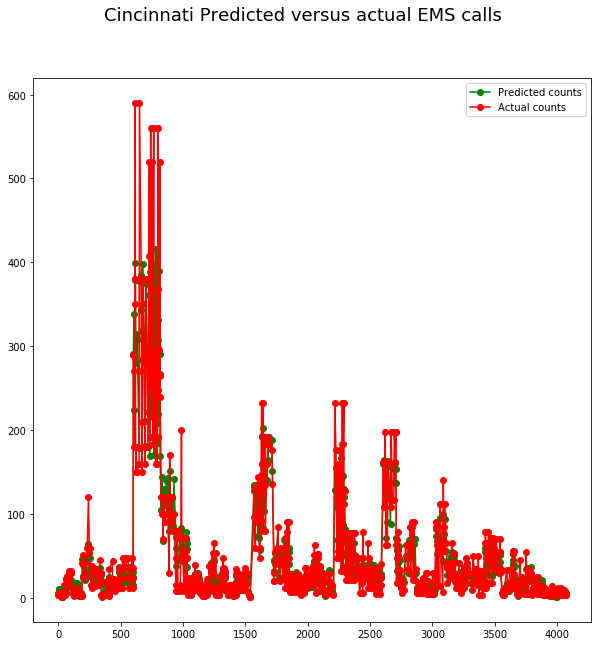

<Figure size 432x288 with 0 Axes>

In [435]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test
fig = plt.figure(figsize=(10,10))
fig.suptitle('Cincinnati Predicted versus actual EMS calls', size=18)
predicted, = plt.plot(predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()
plt.savefig('Cincy_EMS_poisson')

Text(0, 0.5, 'frequency')

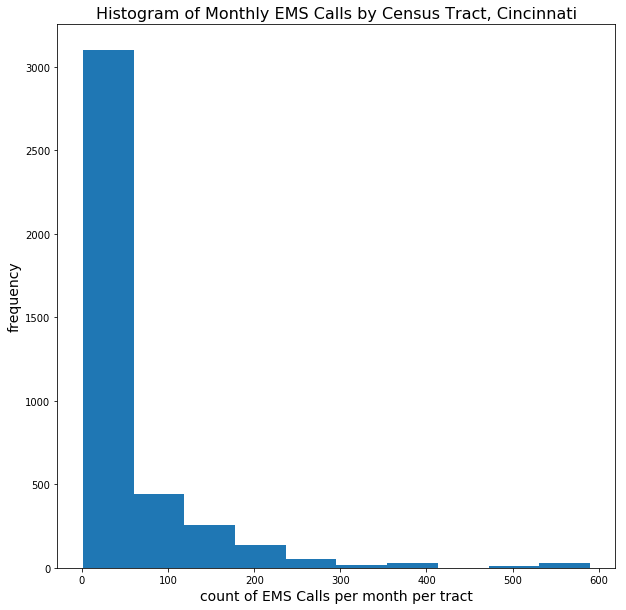

In [436]:
plt.figure(figsize=(10,10))
plt.hist(cin_gdf.ems_call)
plt.title('Histogram of Monthly EMS Calls by Census Tract, Cincinnati', size=16)
plt.xlabel('count of EMS Calls per month per tract', size=14)
plt.ylabel('frequency', size=14)

In [53]:
var = ['CensusTract', 'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi', 'SurgicalCentersCount2mi',
       'UrgentCareCount2mi', 'WomensClinicsCount2mi', 'PainManagementCount2mi','PhysicalTherapyCount2mi'
       'MentalFacilitiesCount2mi', 'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi', 
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi', 'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi',
       'PharmCount2mi', 'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'Med_HHD_Inc_ACS_13_17',
       'pct_College_ACS_13_17', 'pct_Males_ACS_13_17', 'pct_Pop_18_24_ACS_13_17', 'pct_Pop_25_44_ACS_13_17', 'year_month',
       'ems_call']


### Logit

In [623]:
dfl=cin_gdf_1
#dfl.dropna(inplace=True)
#dfl = cin_gdf.filter(var)

In [624]:
dfl.head()
print(np.median(dfl['ems_call']))
print(dfl.ems_call[3])
print(dfl.ems_call)

24.0
6
0         3
1         3
2         6
3         6
4        18
5         6
6         6
7        12
8         3
9         3
10        6
11        6
12       18
13        6
14        6
15       12
16        3
17        3
18        6
19        6
20       18
21        6
22        6
23       12
24        2
25        3
26        1
27        1
28        1
29        1
30        1
31        1
32        1
33        2
34        1
35       11
36        3
37        2
38        1
39        3
40        4
41        3
42        1
43        1
44        4
45        6
46       16
47        4
48        2
49        4
50        6
51        6
52        8
53        4
54        6
55       16
56        4
57        2
58        4
59        6
60        6
61        8
62       16
63       16
64       22
65       26
66       26
67       22
68        8
69       32
70       20
71       16
72       14
73       12
74       16
75       16
76       22
77       26
78       26
79       22
80        8
81       32
82       

In [625]:
dfl['ems_flag'] = 0 
median=np.median(dfl['ems_call'])

In [626]:
for i in range(len(dfl)):
    if i in dfl.index and dfl.ems_call[i] >= median:
        dfl.ems_flag[i] = 1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [627]:
dfl.ems_flag.value_counts()

1    2152
0    1906
Name: ems_flag, dtype: int64

(array([1906.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2152.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

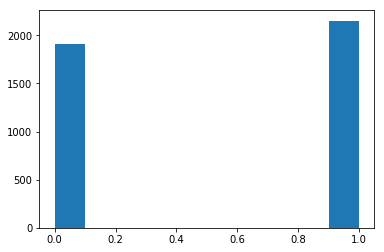

In [628]:
plt.hist(dfl.ems_flag)

In [629]:
np.median(dfl.ems_call)

24.0

(array([3089.,  445.,  254.,  136.,   54.,   18.,   26.,    0.,    8.,
          28.]),
 array([  1. ,  59.9, 118.8, 177.7, 236.6, 295.5, 354.4, 413.3, 472.2,
        531.1, 590. ]),
 <a list of 10 Patch objects>)

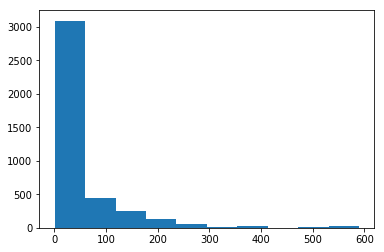

In [630]:
plt.hist(dfl.ems_call)

In [631]:
dfl.dropna(inplace=True)
yl = dfl.ems_flag
print(yl)
Xl = dfl

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
30      0
31      0
32      0
33      0
34      0
35      0
36      0
37      0
38      0
39      0
40      0
41      0
42      0
43      0
44      0
45      0
46      0
47      0
48      0
49      0
50      0
51      0
52      0
53      0
54      0
55      0
56      0
57      0
58      0
59      0
60      0
61      0
62      0
63      0
64      0
65      1
66      1
67      0
68      0
69      1
70      0
71      0
72      0
73      0
74      0
75      0
76      0
77      1
78      1
79      0
80      0
81      1
82      0
83      0
84      0
85      0
86      0
87      1
88      0
89      1
90      1
91      1
92      1
93      1
94      1
95      0
96      0
97      0
98      0
99      1


In [632]:
Xl.drop('ems_flag', inplace=True, axis=1)

In [645]:
#Xl.dropna(inplace=True)
#print(Xl.columns)
"""for i in range(24):
    print (Xl.iloc[:,i].unique())"""
"""for col in Xl:
    print Xl[col].unique()"""
Xl_exp=Xl.iloc[:,:24]

In [646]:
res = sm.Logit(yl, Xl_exp).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.556794
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ems_flag   No. Observations:                 4058
Model:                          Logit   Df Residuals:                     4034
Method:                           MLE   Df Model:                           23
Date:                Tue, 04 Feb 2020   Pseudo R-squ.:                  0.1946
Time:                        20:17:25   Log-Likelihood:                -2259.5
converged:                       True   LL-Null:                       -2805.3
                                        LLR p-value:                4.053e-216
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
HospitalsGeneralCount2mi          0.5030      0.047     10.594      0.000       0.410       0.596
HospitalsPsychCount2mi           -0.4487      0.144     -3.112      0.002      -0.731      -0.166
SurgicalCentersCount2mi           0.1939      0.040      4.837      0.000       0.115       0.272
UrgentCareCount2mi               -0.6295      0.069     -9.081      0.000      -0.765      -0.494
PainManagementCount2mi            0.8610      0.102      8.457      0.000       0.661       1.061
MentalFacilitiesCount2mi         -0.4938      0.058     -8.561      0.000      -0.607      -0.381
NursingAssistedLiveCount2mi       0.0801      0.018      4.339      0.000       0.044       0.116
HospiceCount2mi                   0.2926      0.091      3.215      0.001       0.114       0.471
ChildFacilitiesCount2mi           1.0320      0.092     11.264      0.000       0.852       1.212
DrugDropCount2mi                 -0.1484      0.058     -2.540      0.011      -0.263      -0.034
NaloxoneDistribCount2mi          -0.0254      0.012     -2.129      0.033      -0.049      -0.002
Median_Age_ACS_13_17             -0.0053      0.006     -0.832      0.405      -0.018       0.007
pct_College_ACS_13_17            -0.0112      0.003     -3.832      0.000      -0.017      -0.005
pct_Not_HS_Grad_ACS_13_17         0.0100      0.007      1.355      0.175      -0.004       0.024
pct_NoHealthIns_65P_ACS_13_17    -0.0251      0.014     -1.761      0.078      -0.053       0.003
pct_NH_White_alone_ACS_13_17     -0.0013      0.002     -0.702      0.483      -0.005       0.002
pct_NH_AIAN_alone_ACS_13_17       0.0748      0.076      0.987      0.324      -0.074       0.223
pct_Males_ACS_13_17               0.0457      0.008      5.585      0.000       0.030       0.062
pct_Pop_18_24_ACS_13_17           0.0096      0.004      2.384      0.017       0.002       0.017
pct_Prs_Blw_Pov_Lev_ACS_13_17    -0.0164      0.004     -3.693      0.000      -0.025      -0.008
pct_One_Health_Ins_ACS_13_17     -0.0266      0.005     -5.593      0.000      -0.036      -0.017
pct_Civ_unemp_16_24_ACS_13_17     0.0051      0.003      1.686      0.092      -0.001       0.011
pct_Civ_unemp_45_64_ACS_13_17    -0.0121      0.007     -1.858      0.063      -0.025       0.001
pct_PUB_ASST_INC_ACS_13_17       -0.0226      0.011     -2.141      0.032      -0.043      -0.002
=================================================================================================
"""

In [647]:
np.exp(res.params)

HospitalsGeneralCount2mi         1.653687
HospitalsPsychCount2mi           0.638449
SurgicalCentersCount2mi          1.213998
UrgentCareCount2mi               0.532870
PainManagementCount2mi           2.365555
MentalFacilitiesCount2mi         0.610318
NursingAssistedLiveCount2mi      1.083400
HospiceCount2mi                  1.339966
ChildFacilitiesCount2mi          2.806641
DrugDropCount2mi                 0.862089
NaloxoneDistribCount2mi          0.974964
Median_Age_ACS_13_17             0.994669
pct_College_ACS_13_17            0.988816
pct_Not_HS_Grad_ACS_13_17        1.010046
pct_NoHealthIns_65P_ACS_13_17    0.975236
pct_NH_White_alone_ACS_13_17     0.998676
pct_NH_AIAN_alone_ACS_13_17      1.077635
pct_Males_ACS_13_17              1.046748
pct_Pop_18_24_ACS_13_17          1.009604
pct_Prs_Blw_Pov_Lev_ACS_13_17    0.983733
pct_One_Health_Ins_ACS_13_17     0.973757
pct_Civ_unemp_16_24_ACS_13_17    1.005158
pct_Civ_unemp_45_64_ACS_13_17    0.987970
pct_PUB_ASST_INC_ACS_13_17       0

In [648]:
df3 = cin_gdf.corr()

In [649]:
df4 = pd.DataFrame(df3['ems_call'])

In [650]:
df4[:21]

,ems_call
CensusTract,-0.313467
HospitalsGeneralCount2mi,0.133426
HospitalsPsychCount2mi,-0.128839
SurgicalCentersCount2mi,0.053537
UrgentCareCount2mi,0.067375
WomensClinicsCount2mi,0.184182
PainManagementCount2mi,0.465360
PhysicalTherapyCount2mi,0.081933
MentalFacilitiesCount2mi,0.189462
SubstanceAbuseCount2mi,0.188836


In [651]:
fac_cv = fac

In [652]:
fac_cv.drop(['CensusTract', 'geometry'], axis=1, inplace=True)

In [653]:
fac_cv.corr()

,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,HospitalsChildCount2mi,ChildFacilitiesCount2mi,PharmCount2mi,DrugDropCount2mi,NaloxoneDistribCount2mi
HospitalsGeneralCount2mi,1.000000,-0.050861,0.524646,0.239114,0.789320,0.479889,0.605575,0.875588,0.874814,0.869846,0.254970,0.192215,0.870782,0.113116,0.798115,0.583568,0.590719
HospitalsPsychCount2mi,-0.050861,1.000000,0.239559,0.320285,-0.340792,-0.109352,0.030451,-0.167272,-0.330623,-0.218243,0.086510,0.434665,-0.277636,-0.143933,-0.179874,-0.398126,-0.163773
SurgicalCentersCount2mi,0.524646,0.239559,1.000000,0.689255,0.196868,0.256229,0.612565,0.516155,0.408507,0.433569,0.401352,0.293874,0.445081,-0.072625,0.390919,0.223824,0.269658
UrgentCareCount2mi,0.239114,0.320285,0.689255,1.000000,-0.032461,0.406462,0.572403,0.166696,0.143654,0.197886,0.340390,0.220017,0.076753,0.008957,0.390052,0.013893,0.317820
WomensClinicsCount2mi,0.789320,-0.340792,0.196868,-0.032461,1.000000,0.471689,0.463273,0.745741,0.828167,0.870911,0.024375,-0.047493,0.718350,0.290520,0.734940,0.525049,0.491820
PainManagementCount2mi,0.479889,-0.109352,0.256229,0.406462,0.471689,1.000000,0.617746,0.509073,0.584625,0.631693,-0.034100,0.216013,0.337021,0.463310,0.655481,0.410886,0.306703
PhysicalTherapyCount2mi,0.605575,0.030451,0.612565,0.572403,0.463273,0.617746,1.000000,0.589413,0.660610,0.588826,0.415324,0.170470,0.587645,-0.035464,0.603277,0.335971,0.368173
MentalFacilitiesCount2mi,0.875588,-0.167272,0.516155,0.166696,0.745741,0.509073,0.589413,1.000000,0.902296,0.861444,0.189715,0.124904,0.860917,0.239964,0.751826,0.695414,0.444921
SubstanceAbuseCount2mi,0.874814,-0.330623,0.408507,0.143654,0.828167,0.584625,0.660610,0.902296,1.000000,0.907654,0.158804,0.037761,0.890829,0.238242,0.843760,0.699247,0.516618
OtherMedicalFacilitesCount2mi,0.869846,-0.218243,0.433569,0.197886,0.870911,0.631693,0.588826,0.861444,0.907654,1.000000,0.037869,0.163071,0.770799,0.397127,0.825525,0.570479,0.565631


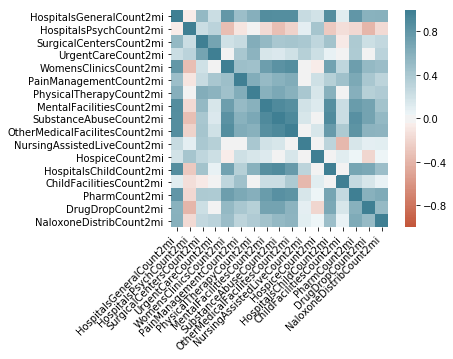

In [89]:
corr = fac.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [90]:
from sklearn.decomposition import PCA

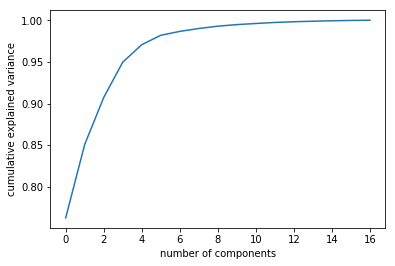

In [93]:
pca = PCA().fit(fac_cv.values)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [96]:
pca_fac = PCA(n_components=2).fit(fac_cv.values)

In [100]:
fac_pca = pd.DataFrame(pca_fac.components_)

In [102]:
fac_pca = fac_pca.T

In [103]:
fac_pca

,0,1
0,0.166887,-0.028480
1,-0.008628,0.005119
2,0.083134,0.000616
3,0.038350,0.127180
4,0.071137,-0.050367
5,0.038401,-0.020975
6,0.054355,0.000802
7,0.132376,-0.100664
8,0.191209,-0.100714
9,0.705516,-0.479155


In [95]:
PCA?

In [84]:
fac_cv.columns

Index(['CensusTract', 'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi',
       'SurgicalCentersCount2mi', 'UrgentCareCount2mi',
       'WomensClinicsCount2mi', 'PainManagementCount2mi',
       'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi',
       'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi',
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi',
       'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi', 'PharmCount2mi',
       'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'geometry'],
      dtype='object')

,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,...,Tract_26400,Tract_26500,Tract_26600,Tract_26700,Tract_26800,Tract_26900,Tract_27000,Tract_27100,Tract_27200,Tract_27400
0,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
1,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
2,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
3,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
4,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
5,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
6,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
7,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
8,2,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
9,2,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ge_ACS_13_17	-0.178175
pct_Males_ACS_13_17	0.207492
pct_Pop_18_24_ACS_13_17	-0.070584
pct_Pop_25_44_ACS_13

In [108]:
cen_corr = cin_gdf.filter(['pct_College_ACS_13_17', 'pct_Males_ACS_13_17', 
                'pct_Pop_18_24_ACS_13_17','pct_Pop_25_44_ACS_13_17'])

In [109]:
cen_corr.corr()

,pct_College_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17
pct_College_ACS_13_17,1.000000,0.219176,0.165182,0.524993
pct_Males_ACS_13_17,0.219176,1.000000,0.414221,0.156665
pct_Pop_18_24_ACS_13_17,0.165182,0.414221,1.000000,-0.319997
pct_Pop_25_44_ACS_13_17,0.524993,0.156665,-0.319997,1.000000


In [111]:
df4[:21]

,ems_call
HospitalsGeneralCount2mi,0.137245
HospitalsPsychCount2mi,-0.029317
SurgicalCentersCount2mi,-0.062300
UrgentCareCount2mi,-0.118978
WomensClinicsCount2mi,0.172335
PainManagementCount2mi,0.257200
PhysicalTherapyCount2mi,-0.001588
MentalFacilitiesCount2mi,0.099455
SubstanceAbuseCount2mi,0.102888
OtherMedicalFacilitesCount2mi,0.210124


In [117]:
pkl_in_Cin = open('cin_pkl', 'rb')

cin = pickle.load(pkl_in_Cin)
print(cin)

      index  CensusTract  HospitalsGeneralCount2mi  HospitalsPsychCount2mi  \
0         0       5200.0                         3                       1   
1         1       5200.0                         3                       1   
2         2       5200.0                         3                       1   
3         3       5200.0                         3                       1   
4         4       5200.0                         3                       1   
...     ...          ...                       ...                     ...   
1233   1233       5000.0                         2                       0   
1234   1234       5000.0                         2                       0   
1235   1235       5000.0                         2                       0   
1236   1236       5100.0                         1                       0   
1237   1237       5100.0                         1                       0   

      SurgicalCentersCount2mi  UrgentCareCount2mi  WomensClinic